<a href="https://colab.research.google.com/github/mikeusru/neural-network-training/blob/main/natural_language_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Generating Shakespearean Text

### Load the Data

In [1]:
import tensorflow as tf
from tensorflow import keras

In [2]:
shakespeare_url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
filepath = keras.utils.get_file("shakespeare.txt", shakespeare_url)
with open(filepath) as f:
    shakespeare_text = f.read()

1122304/1115394 [==============================] - 0s 0us/step


In [11]:
print(shakespeare_text[:300])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us


### Tokenize our text

In [12]:
tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts(shakespeare_text)

In [16]:
tokenizer.texts_to_sequences(["Shakespeare is old lol"])

[[8, 7, 5, 25, 2, 8, 23, 2, 5, 9, 2, 1, 6, 8, 1, 4, 12, 13, 1, 12, 4, 12]]

In [21]:
tokenizer.sequences_to_texts([[8, 7, 5, 25, 2, 8, 23, 2, 5, 9, 2, 1, 6, 8, 1, 4, 12, 13, 1, 12, 4, 12]])

['s h a k e s p e a r e   i s   o l d   l o l']

In [46]:
max_id = len(tokenizer.word_index) # number of distinct characters
dataset_size = tokenizer.document_count
print(f"Total number of characters: {dataset_size}")

Total number of characters: 1115394


In [24]:
import numpy as np

# Encode full text, subtract 1 so it starts from 0 instead of 1
[encoded] = np.array(tokenizer.texts_to_sequences([shakespeare_text])) - 1

In [26]:
encoded.shape

(1115394,)

In [29]:
train_size = dataset_size * 90 // 100
print(f"Training set size: {train_size}")

Training set size: 1003854


In [30]:
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])

### Chop the sequential dataset into multiple windows

In [35]:
n_steps = 100
window_length = n_steps + 1
dataset = dataset.window(window_length, shift=1, drop_remainder=True)

In [37]:
dataset = dataset.flat_map(lambda window: window.batch(window_length))

In [44]:
batch_size = 32
dataset = dataset.shuffle(10000).batch(batch_size)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))

In [47]:
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))

In [48]:
dataset = dataset.prefetch(1)

## Build and train a Char-RNN Model

In [51]:
model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, input_shape=[None, max_id],
                     dropout=0.2),
    keras.layers.GRU(128, return_sequences=True,
                     dropout=0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")


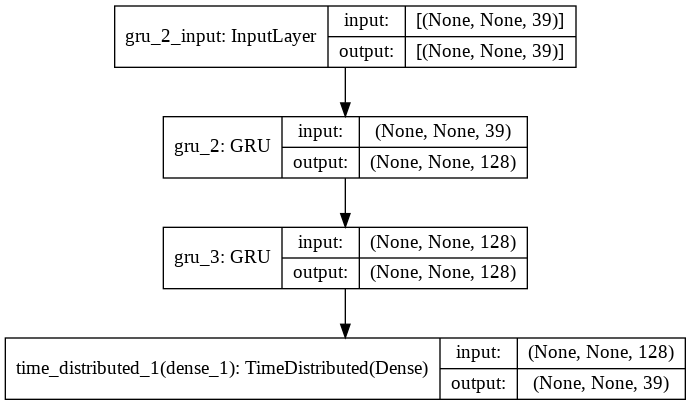

In [55]:
keras.utils.plot_model(model, show_shapes=True)

In [63]:
history = model.fit(dataset, epochs=10)

Epoch 1/10
31368/31368 [==============================] - 364s 12ms/step - loss: 1.5379
Epoch 2/10
31368/31368 [==============================] - 364s 12ms/step - loss: 1.5139
Epoch 3/10
31368/31368 [==============================] - 361s 11ms/step - loss: 1.5009
Epoch 4/10
31368/31368 [==============================] - 357s 11ms/step - loss: 1.4933
Epoch 5/10
31368/31368 [==============================] - 356s 11ms/step - loss: 1.4873
Epoch 6/10
31368/31368 [==============================] - 365s 12ms/step - loss: 1.4838
Epoch 7/10
31368/31368 [==============================] - 369s 12ms/step - loss: 1.4806
Epoch 8/10
31368/31368 [==============================] - 371s 12ms/step - loss: 1.4781
Epoch 9/10
31368/31368 [==============================] - 369s 12ms/step - loss: 1.4768
Epoch 10/10
31368/31368 [==============================] - 371s 12ms/step - loss: 1.4748


In [64]:
model.save("char_rnn_shakespeare.h5")

### Use our model

In [ ]:
model = keras.models.load_model("char_rnn_shakespeare.h5")

In [68]:
def preprocess(texts):
  X = np.array(tokenizer.texts_to_sequences(texts)) - 1
  return tf.one_hot(X, max_id)


In [70]:
X_new = preprocess(["How are yo"])
Y_pred = np.argmax(model.predict(X_new), axis=-1)

#show the first sentence, last character
tokenizer.sequences_to_texts(Y_pred +1)[0][-1] 

'u'

## Generating fake shakespearian text

In [82]:
def next_char(text, temperature=1):
  # temperature close to 0 will favor high probability characters,
  # very high temperature will favor equal probability for all characters
  X_new = preprocess([text])
  y_proba = model.predict(X_new)[0, -1:, :]
  rescaled_logits = tf.math.log(y_proba) / temperature
  # Logits are class log probabilities
  char_id = tf.random.categorical(rescaled_logits, num_samples=1) +1
  return tokenizer.sequences_to_texts(char_id.numpy())[0]

In [73]:
def complete_text(text, n_chars=50, temperature=1):
  for _ in range(n_chars):
    text += next_char(text, temperature)
  return text

In [85]:
print(complete_text("the", temperature=0.2))

the world,
and well you will be rest in padua,
such a


In [86]:
print(complete_text("where", temperature=0.2))

where is not her to my hands, the matter that he will b


In [87]:
print(complete_text("where", temperature=1))

whereof,
perhaps there orawtor's to'tn behald to thee,



In [88]:
print(complete_text("where", temperature=0))

where$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$


In [89]:
print(complete_text("where", temperature=0.1))

where i have a suitors and the world.

gremio:
sir, i w
